<a href="https://colab.research.google.com/github/DerekW00/afterimage-simulation/blob/main/afterimage_test_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation and Testing
## Import Libraries and Define Helper Functions



In [1]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Conversion Matrices
M_rgb_to_lms = torch.tensor([[0.3811, 0.5783, 0.0402],
                               [0.1967, 0.7244, 0.0782],
                               [0.0241, 0.1288, 0.8444]], dtype=torch.float32).to(device)
M_lms_to_rgb = torch.inverse(M_rgb_to_lms)

M_lms_to_orgb = torch.tensor([[1/np.sqrt(3),  1/np.sqrt(3),  1/np.sqrt(3)],
                              [1/np.sqrt(6),  1/np.sqrt(6), -2/np.sqrt(6)],
                              [1/np.sqrt(2), -1/np.sqrt(2),  0]], dtype=torch.float32).to(device)
M_orgb_to_lms = torch.inverse(M_lms_to_orgb)

# Helper functions
def gaussian_kernel(kernel_size=5, sigma=1.5):
    """Generate a 2D Gaussian kernel."""
    ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / kernel.sum()

def convert_color_space(image, M):
    """
    Convert an image tensor using a conversion matrix M.
    Expects image shape [B, 3, H, W].
    """
    B, C, H, W = image.shape
    flat = image.view(B, C, -1)  # [B, 3, N]
    converted = torch.matmul(M, flat)
    return converted.view(B, C, H, W)

def convert_orgb(image_lms, to_orgb=True):
    """Convert between LMS and opponent (oRGB) color spaces."""
    if to_orgb:
        return convert_color_space(image_lms, M_lms_to_orgb)
    else:
        return convert_color_space(image_lms, M_orgb_to_lms)

Using device: cuda


## Define the Pipeline with Debug Outputs

In [2]:
def process_image_debug(image_np, params=None, debug=True):
    """
    Process an input image (as a NumPy array in RGB, normalized [0,1])
    through the afterimage pipeline and return intermediate outputs.

    Optionally, a 'params' dictionary can override default parameters.
    """
    # Default parameters
    p = {
        'kernel_size': 5,
        'sigma_blur': 1.5,
        'c_a': 0.3,
        'c_d': 1.0,
        'dt': 1.0/30.0,
        'num_steps': 30,
        'N_sigma': 10,
        'kernel_size_diff': 5,
        'alpha': 0.5
    }
    if params:
        p.update(params)

    outputs = {}

    # Convert input image to tensor [1,3,H,W]
    img_tensor = torch.tensor(image_np, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
    outputs['original'] = img_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    # Stage 1: Eye Dynamics – Gaussian Blur
    gauss_kernel = gaussian_kernel(p['kernel_size'], p['sigma_blur']).unsqueeze(0).unsqueeze(0).to(device)
    effective_radiance = F.conv2d(img_tensor, gauss_kernel.repeat(3, 1, 1, 1),
                                  padding=p['kernel_size']//2, groups=3)
    outputs['effective_radiance'] = effective_radiance.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    # Stage 2: RGB -> LMS
    effective_radiance_lms = convert_color_space(effective_radiance, M_rgb_to_lms)
    outputs['effective_radiance_lms'] = effective_radiance_lms.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    # Stage 3 & 4: Retinal Kinetics and Diffusion
    r_lms = torch.zeros_like(effective_radiance_lms).to(device)
    sigma_diff = p['N_sigma'] / np.sqrt(30)  # Frame rate assumed 30 fps
    diff_kernel = gaussian_kernel(p['kernel_size_diff'], sigma_diff).unsqueeze(0).unsqueeze(0).to(device)

    for step in range(p['num_steps']):
        r_dot = p['c_a'] * effective_radiance_lms * (1 - r_lms) - p['c_d'] * r_lms
        r_lms = r_lms + p['dt'] * r_dot
        r_lms = torch.clamp(r_lms, 0, 1)
        B, C, H, W = r_lms.shape
        r_lms = F.conv2d(r_lms, diff_kernel.repeat(C, 1, 1, 1), padding=p['kernel_size_diff']//2, groups=C)
    outputs['r_lms'] = r_lms.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    # Stage 5: Opponent Color Transformation
    bleaching_orgb = convert_orgb(r_lms, to_orgb=True)
    outputs['bleaching_orgb'] = bleaching_orgb.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    afterimage_orgb = -bleaching_orgb
    outputs['afterimage_orgb'] = afterimage_orgb.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    afterimage_lms = convert_orgb(afterimage_orgb, to_orgb=False)
    outputs['afterimage_lms'] = afterimage_lms.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    afterimage_rgb = convert_color_space(afterimage_lms, M_lms_to_rgb)
    afterimage_rgb = torch.clamp(afterimage_rgb, 0, 1)
    outputs['afterimage_rgb'] = afterimage_rgb.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    # Stage 6: Composite with effective radiance
    final_output = (1 - p['alpha']) * effective_radiance + p['alpha'] * afterimage_rgb
    final_output = torch.clamp(final_output, 0, 1)
    outputs['final_output'] = final_output.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    if debug:
        stage_names = ['original', 'effective_radiance', 'effective_radiance_lms',
                       'r_lms', 'bleaching_orgb', 'afterimage_orgb',
                       'afterimage_lms', 'afterimage_rgb', 'final_output']
        plt.figure(figsize=(15, 10))
        for i, name in enumerate(stage_names):
            plt.subplot(3, 3, i+1)
            # Note: Some stages (like LMS or oRGB) might need special scaling for display.
            plt.imshow(outputs[name])
            plt.title(name)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return outputs

## Evaluate the Pipeline on Images

Processing /content/drive/MyDrive/Colab Notebooks/afterimage/input_image/0.jpg


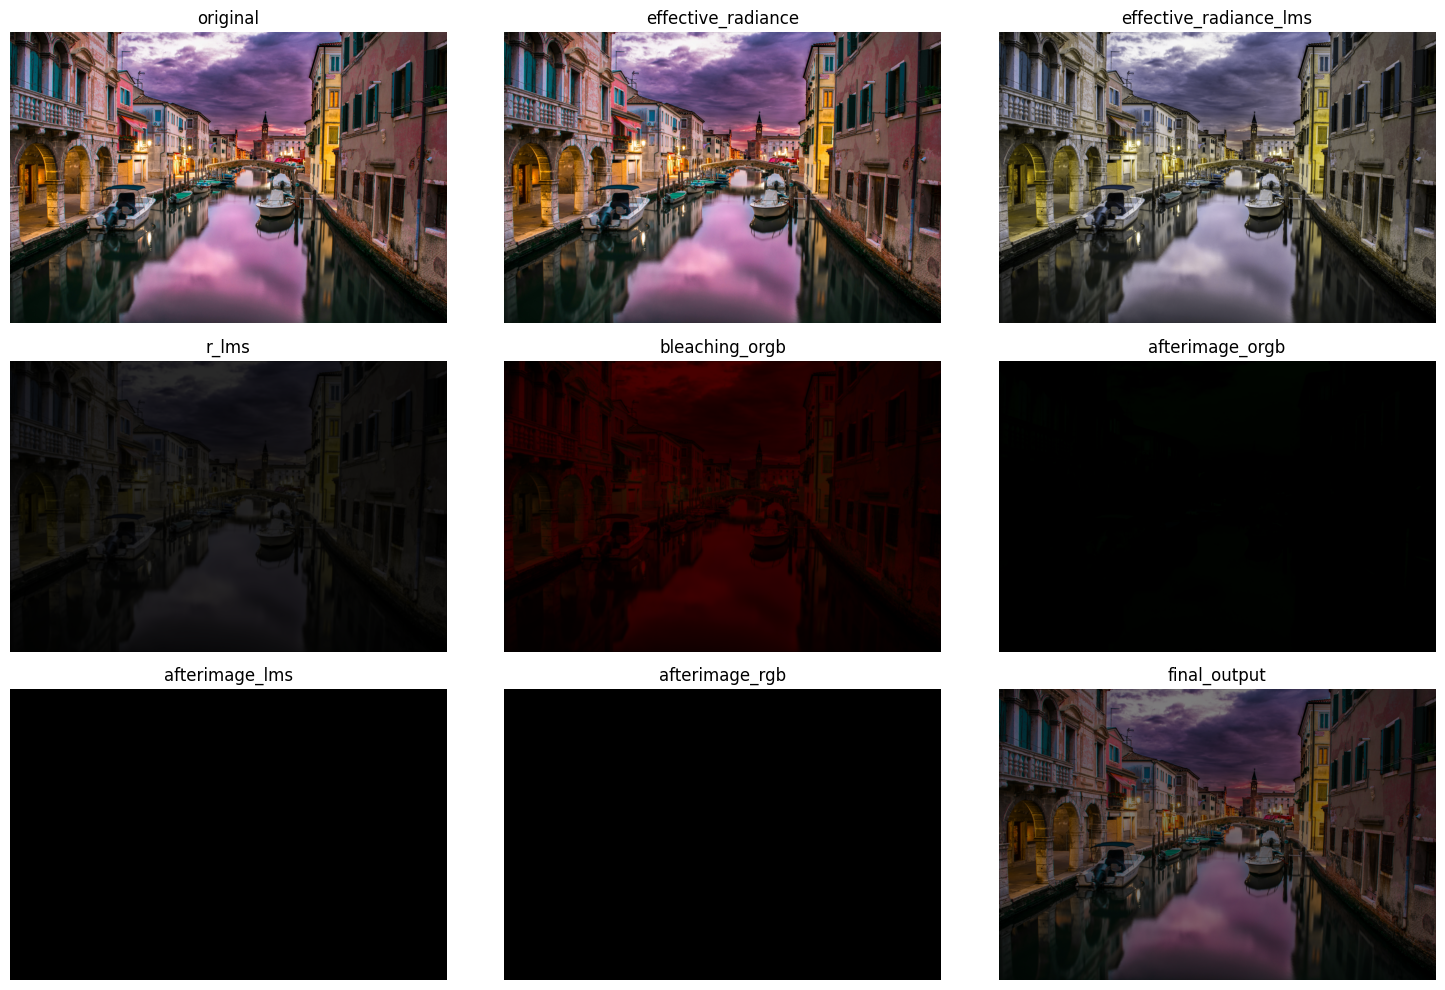

In [3]:
# List of filenames from 0.jpg to 9.jpg
filenames = [f"/content/drive/MyDrive/Colab Notebooks/afterimage/input_image/{i}.jpg" for i in range(1)]

for fname in filenames:
    img_bgr = cv2.imread(fname)
    if img_bgr is None:
        print(f"File {fname} not found.")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) / 255.0
    print("Processing", fname)
    outputs = process_image_debug(img_rgb, debug=True)

In [4]:
import time

def measure_pipeline_performance(image_np, num_iterations=20):
    """
    Process the image through the pipeline for a given number of iterations,
    measure the average time per frame, and compute the pixel throughput.
    """
    # Warm up GPU (run a few iterations to avoid initial overhead)
    for _ in range(3):
        _ = process_image_debug(image_np, debug=False)
        torch.cuda.synchronize()

    # Get image dimensions (assuming image_np shape is H x W x 3)
    H, W, _ = image_np.shape
    total_pixels = H * W

    # Measure performance
    torch.cuda.synchronize()
    start_time = time.time()
    for i in range(num_iterations):
        _ = process_image_debug(image_np, debug=False)
        # Ensure all GPU computations are finished before timing next iteration
        torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_frame = total_time / num_iterations
    pixels_per_second = total_pixels / avg_time_per_frame
    megapixels_per_second = pixels_per_second / 1e6

    print(f"Processed {num_iterations} iterations in {total_time:.4f} seconds.")
    print(f"Average time per frame: {avg_time_per_frame:.4f} seconds.")
    print(f"Pixel throughput: {megapixels_per_second:.2f} Megapixels/sec.")

    return avg_time_per_frame, megapixels_per_second

# Load a test image (e.g., "0.jpg") from your directory:
img_bgr = cv2.imread("/content/drive/MyDrive/Colab Notebooks/afterimage/input_image/0.jpg")
if img_bgr is None:
    raise FileNotFoundError("0.jpg not found in the directory.")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) / 255.0

# Run the performance measurement:
measure_pipeline_performance(img_rgb, num_iterations=20)

Processed 20 iterations in 66.9261 seconds.
Average time per frame: 3.3463 seconds.
Pixel throughput: 7.17 Megapixels/sec.


(3.3463034987449647, 7.172093030115538)

In [ ]:

# Load your test image (normalized RGB)
img_bgr = cv2.imread("/content/drive/MyDrive/Colab Notebooks/afterimage/input_image/0.jpg")
if img_bgr is None:
    raise FileNotFoundError("0.jpg not found.")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) / 255.0

# Define lists of parameter values to test
# Here we vary only 'alpha' for demonstration; you can add more parameters
alpha_values = [0.3, 0.5, 0.7]
# We'll keep these fixed in this example:
fixed_c_a = 0.3
fixed_c_d = 1.0

# Dictionary to hold results
results = {}

# Loop over parameter values
for alpha in alpha_values:
    params = {
        'alpha': alpha,
        'c_a': fixed_c_a,
        'c_d': fixed_c_d
    }
    print(f"Processing with parameters: {params}")
    # Process the image using your debug pipeline without displaying the grid
    output = process_image_debug(img_rgb, params=params, debug=False)
    results[(alpha, fixed_c_a, fixed_c_d)] = output
    # Clear GPU cache to prevent memory buildup
    torch.cuda.empty_cache()

# Now, display the final outputs side-by-side for comparison.
n = len(alpha_values)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
for i, alpha in enumerate(alpha_values):
    key = (alpha, fixed_c_a, fixed_c_d)
    ax = axes[i] if n > 1 else axes
    ax.imshow(results[key])
    ax.set_title(f"alpha: {alpha}")
    ax.axis("off")
plt.suptitle("Final Output for Different Alpha Values", fontsize=16)
plt.tight_layout()
plt.show()

Processing with parameters: {'alpha': 0.3, 'c_a': 0.3, 'c_d': 1.0}
Processing with parameters: {'alpha': 0.5, 'c_a': 0.3, 'c_d': 1.0}
Processing with parameters: {'alpha': 0.7, 'c_a': 0.3, 'c_d': 1.0}


In [ ]:
# Create interactive sliders for key parameters
alpha_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Alpha:')
c_a_slider = widgets.FloatSlider(value=0.3, min=0.1, max=1.0, step=0.05, description='c_a:')
c_d_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='c_d:')

def interactive_pipeline(alpha, c_a, c_d):
    params = {
        'alpha': alpha,
        'c_a': c_a,
        'c_d': c_d
    }
    # For demonstration, use one image (e.g., "0.jpg")
    img_bgr = cv2.imread("/content/drive/MyDrive/Colab Notebooks/afterimage/input_image/0.jpg")
    if img_bgr is None:
        print("Image 0.jpg not found.")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) / 255.0
    outputs = process_image_debug(img_rgb, params=params, debug=True)
    plt.figure(figsize=(6,4))
    plt.imshow(outputs['final_output'])
    plt.title("Final Output with Adjusted Parameters")
    plt.axis('off')
    plt.show()

widgets.interact(interactive_pipeline, alpha=alpha_slider, c_a=c_a_slider, c_d=c_d_slider)